## colab setting ,read file and import module
* 注意此次資料集為lag5(以前五個月預測當月)，若要其他月份要重切，到時候有空再研究有沒有辦法當場切

In [127]:
#!pip install google.colab #如未安裝取消註解後執行
import os
from google.colab import drive
drive.mount('/content/my_drive')

Drive already mounted at /content/my_drive; to attempt to forcibly remount, call drive.mount("/content/my_drive", force_remount=True).


In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
# file_path = '/content/my_drive/MyDrive/BDSE34期末報告_房價/all_data/detailed_usage_data_for_NNs.csv'
file_path = '/content/my_drive/MyDrive/BDSE34期末報告_房價/all_data/c591_final_detailed_usage_full_main_data_for_xgb_v2.csv'
df = pd.read_csv(file_path)

In [129]:
import numpy as np
import joblib
import pandas as pd
import datetime
import tensorflow as tf
import os
import random
import timeit

import seaborn as sns
import datetime
import matplotlib.pyplot as plt

from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Bidirectional, Dropout, Flatten, GlobalAveragePooling1D, GlobalMaxPooling1D, Reshape, Multiply, GRU, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.initializers import GlorotUniform

## CBAM layer (1D version)

In [130]:
class CBAMLayer(tf.keras.Model):
    def __init__(self, channel, reduction=16, spatial_kernel=7):   # 作者預設: reduction=16, spatial_kernel=7(這是論文設定值，可能有神麼意義?)
        super(CBAMLayer, self).__init__()
        self.channel = channel

        # Channel attention
        self.max_pool = GlobalMaxPooling1D()
        self.avg_pool = GlobalAveragePooling1D()

        self.mlp = tf.keras.Sequential([
            Dense(channel // reduction, use_bias=False), # 利用channel除以reduction，壓縮到縮到一個維度較低的空間
            tf.keras.layers.Activation('relu'),
            Dense(channel, use_bias=False)               # 然後再過一個回到channel數量的維度
        ])

        # Spatial attention
        self.conv = Conv1D(1, (spatial_kernel), padding='same', use_bias=False)
        self.sigmoid = tf.keras.layers.Activation('sigmoid')

    # 這應該是繼承來overwrite(或是實作(本來可能根本沒寫(抽象方法的概念)))的方法，定義好之後因為keras每一層會自動訓練，所以裏頭也就是會去呼叫這個叫做call()的方法，所以這個名子不能去改
    def call(self, x):
        max_out = self.mlp(Reshape((1, self.channel))(self.max_pool(x))) # MLP轉換 # x是輸入的張量 # Reshape將self.max_pool(x)出來的值的形狀改成(1, self.channel)，基本上在這裡self.max_pool(x)的形狀應該會是(32,)，因為總共有32個filter，這樣做是因為TensorFlow Dense層要求的input shape 為 (#batch_size(反正就是樣本數), #input_dimension)，只有一筆所以就給1，然後是32個特徵(維)，寫法蠻神奇的要注意一下
        avg_out = self.mlp(Reshape((1, self.channel))(self.avg_pool(x))) # MLP轉換
        channel_out = self.sigmoid(max_out + avg_out)   # 經MLP轉換後的maxpooling跟averagepooling相加後，再過一個sigmoid
        x = Multiply()([channel_out, x])

        max_out = tf.reduce_max(x, axis=2, keepdims=True)
        avg_out = tf.reduce_mean(x, axis=2, keepdims=True)
        spatial_out = self.sigmoid(self.conv(tf.concat([max_out, avg_out], axis=2)))
        x = Multiply()([spatial_out, x])
        return x

## time series window create

In [131]:
only_eco_file_path = '/content/my_drive/MyDrive/BDSE34期末報告_房價/all_data/final_eco_df_to_11306_fillna_v2.csv'
only_eco_df = pd.read_csv(only_eco_file_path, encoding='utf-8')

In [132]:
only_eco_df.drop('year_month_for_combine', axis=1, inplace=True)

In [133]:
# to create eco lag shift data
def create_windows_of_each_eco_index(only_eco_df: pd.DataFrame, windows_size):
  vars_shift_df = only_eco_df.iloc[:,0:2]
  vars_shift_df.columns = ['date', 'target_index_house_index_xyi_all_tp']
  col_vars = only_eco_df.columns.drop('date')
  for lag in range(1, windows_size+1, 1):
    for eco_name in col_vars:
        var = eco_name
        vars_shift_df[f'{var}_lag_{lag}'] = only_eco_df[var].shift(lag)
  vars_shift_df.fillna(method='bfill', inplace=True)
  return vars_shift_df

In [134]:
# 經濟指數有23個 (window_size=n, eco_index=23)
window_df_5 = create_windows_of_each_eco_index(only_eco_df, 5) # 目前做12個月

<ipython-input-133-abb8de1a450b>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars_shift_df[f'{var}_lag_{lag}'] = only_eco_df[var].shift(lag)
<ipython-input-133-abb8de1a450b>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars_shift_df[f'{var}_lag_{lag}'] = only_eco_df[var].shift(lag)
<ipython-input-133-abb8de1a450b>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1

In [135]:
window_df_5.info(max_cols=117)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 117 columns):
 #    Column                               Non-Null Count  Dtype  
---   ------                               --------------  -----  
 0    date                                 162 non-null    object 
 1    target_index_house_index_xyi_all_tp  162 non-null    float64
 2    house_index_xyi_all_tp_lag_1         162 non-null    float64
 3    house_index_xyi_tp_lag_1             162 non-null    float64
 4    house_index_xyi_new_tp_lag_1         162 non-null    float64
 5    EB18_lag_1                           162 non-null    float64
 6    EB21_lag_1                           162 non-null    float64
 7    MC31_lag_1                           162 non-null    float64
 8    MC31G_lag_1                          162 non-null    float64
 9    MC36_lag_1                           162 non-null    float64
 10   NA0101_lag_1                         162 non-null    float64
 11   NA1005_lag_1     

In [136]:
window_df_5['date'] = pd.to_datetime(window_df_5['date'])
window_df_5['year_month_for_combine'] = window_df_5['date'].dt.to_period('M')
df['year_month_for_combine'] = pd.to_datetime(df['year_month_for_combine'])
df['year_month_for_combine'] = df['year_month_for_combine'].dt.to_period('M')

<ipython-input-136-efd557384d7f>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  window_df_5['year_month_for_combine'] = window_df_5['date'].dt.to_period('M')


In [137]:
nn_final_df = df.merge(window_df_5, left_on='year_month_for_combine', right_on='year_month_for_combine', how='inner')

In [138]:
nn_final_df.drop(['date'], axis=1, inplace=True)

## 分X, y (要先切分test, train, validation，再來分time, non_time)

In [139]:
nn_final_df.info(max_cols=213)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669734 entries, 0 to 669733
Data columns (total 213 columns):
 #    Column                                Non-Null Count   Dtype    
---   ------                                --------------   -----    
 0    community_name                        669734 non-null  int64    
 1    main_building_ratio                   669734 non-null  float64  
 2    building_age                          669734 non-null  float64  
 3    total_area_ping                       669734 non-null  float64  
 4    total_floors                          669734 non-null  float64  
 5    target_floor                          669734 non-null  float64  
 6    transaction_floors                    669734 non-null  float64  
 7    bedrooms                              669734 non-null  float64  
 8    living_rooms                          669734 non-null  float64  
 9    bathrooms                             669734 non-null  float64  
 10   year_month_for_combine        

In [140]:
df = nn_final_df.copy()

In [141]:
main_df_col_list = df.columns

In [142]:
df.info(max_cols=213)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669734 entries, 0 to 669733
Data columns (total 213 columns):
 #    Column                                Non-Null Count   Dtype    
---   ------                                --------------   -----    
 0    community_name                        669734 non-null  int64    
 1    main_building_ratio                   669734 non-null  float64  
 2    building_age                          669734 non-null  float64  
 3    total_area_ping                       669734 non-null  float64  
 4    total_floors                          669734 non-null  float64  
 5    target_floor                          669734 non-null  float64  
 6    transaction_floors                    669734 non-null  float64  
 7    bedrooms                              669734 non-null  float64  
 8    living_rooms                          669734 non-null  float64  
 9    bathrooms                             669734 non-null  float64  
 10   year_month_for_combine        

In [143]:
df[ (df['year_month_for_combine'] > '2024-03-31') ].info()

<class 'pandas.core.frame.DataFrame'>
Index: 5298 entries, 664436 to 669733
Columns: 213 entries, community_name to 預拌混凝土3000磅台北_lag_5
dtypes: float64(161), int64(51), period[M](1)
memory usage: 8.6 MB


In [144]:
df = df.sort_values(by='year_month_for_combine', ascending=True)

In [145]:
# 轉回datetime物件才可以使用
# df['year_month_for_combine'] = df['year_month_for_combine'].dt.to_timestamp()

In [146]:
# df['year'] = df['year_month_for_combine'].dt.year

In [147]:
# df.drop('year_month_for_combine', axis=1, inplace=True)

In [148]:
train_data = df[df['year_month_for_combine'] <= '2023-03-31']
validation_data = df[ (df['year_month_for_combine'] > '2023-03-31') & (df['year_month_for_combine'] <= '2024-03-31')]
final_test_data = df[ (df['year_month_for_combine'] > '2024-03-31') ]

In [149]:
train_data.shape, validation_data.shape, final_test_data.shape

((614268, 213), (50168, 213), (5298, 213))

In [150]:
validation_data['year_month_for_combine']

601656    2023-04
601671    2023-04
601672    2023-04
601673    2023-04
601674    2023-04
           ...   
556861    2024-03
556860    2024-03
556867    2024-03
556859    2024-03
556858    2024-03
Name: year_month_for_combine, Length: 50168, dtype: period[M]

In [151]:
train_data.info(max_cols=213)

<class 'pandas.core.frame.DataFrame'>
Index: 614268 entries, 248513 to 607860
Data columns (total 213 columns):
 #    Column                                Non-Null Count   Dtype    
---   ------                                --------------   -----    
 0    community_name                        614268 non-null  int64    
 1    main_building_ratio                   614268 non-null  float64  
 2    building_age                          614268 non-null  float64  
 3    total_area_ping                       614268 non-null  float64  
 4    total_floors                          614268 non-null  float64  
 5    target_floor                          614268 non-null  float64  
 6    transaction_floors                    614268 non-null  float64  
 7    bedrooms                              614268 non-null  float64  
 8    living_rooms                          614268 non-null  float64  
 9    bathrooms                             614268 non-null  float64  
 10   year_month_for_combine        

In [152]:
X_train = train_data.drop(['new_per_ping', 'year_month_for_combine'], axis=1).values
y_train = train_data['new_per_ping'].values

X_validation = validation_data.drop(['new_per_ping', 'year_month_for_combine'], axis=1).values
y_validation = validation_data['new_per_ping'].values

X_final_test = final_test_data.drop(['new_per_ping', 'year_month_for_combine'], axis=1).values
y_final_test = final_test_data['new_per_ping'].values

In [153]:
X_train.shape, X_validation.shape, X_final_test.shape

((614268, 211), (50168, 211), (5298, 211))

In [154]:
# 非時間間的特徵從[0:119], 時間特徵[120:]
# y每一筆資料只有一個值，就不用動了

# train
non_time_train = X_train[:,0:95]
time_series_train = X_train[:,96:] # 119是時間序列月的target_y，就先不要了

# validation
non_time_validation = X_validation[:,0:95]
time_series_validation = X_validation[:,96:]

# # test
non_time_test = X_final_test[:,0:95]
time_series_test = X_final_test[:,96:]

In [155]:
print(non_time_train.shape)
print(time_series_train.shape)
print(time_series_test.shape)

(614268, 95)
(614268, 115)
(5298, 115)


## 處理正規化、正則化
* 我知道了non_time就用minmax(這樣特徵就可以保持原樣了...)記先這樣吧
* times就用standardlize

In [156]:
# 非時間特徵用的(這樣one-hot的欄位不受影響，真要要用StandardScaler就要切蘭為了)
from sklearn.preprocessing import MinMaxScaler
mm_scaler_for_non = MinMaxScaler()
non_time_train = mm_scaler_for_non.fit_transform(non_time_train) # 只有訓練資料可以fit，之後都使用訓練資料fit出來的結果作transform
non_time_validation = mm_scaler_for_non.transform(non_time_validation)
non_time_test = mm_scaler_for_non.transform(non_time_test)

# 時間特徵用的(使用標準化的效果校佳)
from sklearn.preprocessing import StandardScaler
scaler_for_time = StandardScaler()
time_series_train = scaler_for_time.fit_transform(time_series_train)
time_series_validation = scaler_for_time.transform(time_series_validation)
time_series_test = scaler_for_time.transform(time_series_test)


## 試試看統一用minmaxscaler
# from sklearn.preprocessing import StandardScaler
# scaler_for_time = MinMaxScaler()
# time_series_train = scaler_for_time.fit_transform(time_series_train)
# time_series_validation = scaler_for_time.transform(time_series_validation)
# time_series_test = scaler_for_time.transform(time_series_test)


## 先來處理非時間特徵模型

In [157]:
feature_shape = non_time_train.shape[1]

In [158]:
# 非時間特徵的模型
# 定義模型層數堆疊 (以class Model建立模型的方式，就只是每一層都有一個輸出，然後下一層繼續接輸出而以)
input_non_time_feature = Input(shape=feature_shape)
y = Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42), kernel_regularizer= tf.keras.regularizers.l2(0.001),)(input_non_time_feature)
# y = Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))(y)
# y = Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))(y)
# y = Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))(y)
# y = Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42), kernel_regularizer= tf.keras.regularizers.l2(0.001))(y)
# y = Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42), kernel_regularizer= tf.keras.regularizers.l2(0.001))(y)
y = Dense(32, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42), kernel_regularizer= tf.keras.regularizers.l2(0.001))(y)
y = Dense(32, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42), kernel_regularizer= tf.keras.regularizers.l2(0.001),)(y)
model_non_time = Model(inputs=input_non_time_feature, outputs=y)

## 時間相關的的特徵整理與模型

In [159]:
# 更改成可以餵入ConV1D的形式
# 拿來放要用的資料形式(X:2D)
arry_index = time_series_train.shape[0] # 抓總筆數
X_shift_list = []

for each_index in range(arry_index):
    # 每一筆資料抓出來
    each_array = time_series_train[each_index].reshape(5,23)

    X_shift_list.append(each_array)

In [160]:
# list要轉乘array才可以丟模型
X_times_train = np.array(X_shift_list)
X_times_train.shape

(614268, 5, 23)

In [161]:
arry_index_v = time_series_validation.shape[0] # 抓總筆數   # time_series_validation
X_shift_list_v = []

for each_index in range(arry_index_v):
    # 每一筆資料抓出來
    each_array_v = time_series_validation[each_index].reshape(5,23)

    X_shift_list_v.append(each_array_v)

X_times_validation = np.array(X_shift_list_v)
X_times_validation.shape

(50168, 5, 23)

In [162]:
arry_index_t = time_series_test.shape[0] # 抓總筆數   # time_series_test
X_shift_list_t = []

for each_index in range(arry_index_t):
    # 每一筆資料抓出來
    each_array_t = time_series_test[each_index].reshape(5,23)

    X_shift_list_t.append(each_array_t)

X_times_test = np.array(X_shift_list_t)
X_times_test.shape

(5298, 5, 23)

In [163]:
# 定義Conv1D模型 (這樣堆疊是可以的)
time_feature_input = Input(shape=(5, 23))  # (#timestamp=5, #feature=36)
# x = Conv1D(filters=32, kernel_size=3, strides=1, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))(time_feature_input)
# x = BatchNormalization()(x)
# x = CBAMLayer(channel=32)(x) # channels數要與上一層的Conv1D filters數一樣
# x = BatchNormalization()(x)
# x = Conv1D(filters=64, kernel_size=3, strides=1, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))(x)
# x = BatchNormalization()(x)
x = LSTM(5, return_sequences=False, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))(time_feature_input)

# x = Flatten()(time_feature_input)
# x = Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))(x)
x = BatchNormalization()(x)
# x = Dropout(0.5)(x)
# x = Bidirectional(LSTM(6, return_sequences=True))(x)
# x = Bidirectional(LSTM(6, return_sequences=True))(x)
# x = Flatten()(x)
# x = Dense(32, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))(x)
# x = Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))(x)
# x = Dropout(0.5)(x)
x = Dense(32, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))(x)
x = BatchNormalization()(x)
time_model = Model(inputs=time_feature_input, outputs=x)

## 幾個epoch就做保存模型的動作，若要繼續續練模型，只需要加載回原先儲存的模型，繼續.fit()就會繼續訓練拉

In [164]:
from tensorflow.keras.callbacks import ModelCheckpoint # 使用此設定每幾個epoch就儲存一次模型
checkpoint_seq = ModelCheckpoint('/content/my_drive/MyDrive/BDSE34期末報告_房價/trained_models/full_data_version_with_time_split_CNN_CBAM{epoch:03d}.h5', save_freq='epoch', period=15)
# model_seq_{epoch:03d}.h5這應該是檔名?!        # save_freq=<數值>，表示多少batch儲存一次模型(注意每過一個batch size是一個iteration)，看過全部資料才是一個Epoch
# period有可能不能用，有問題的話注意一下

### 並在模型訓練時透過callbacks參數指定(設定)
# model_seq.fit(X_seq, y_true, epochs=1000, batch_size=32, callbacks=[checkpoint_seq])

## 其他定義
* EarlyStopping
* LearningRateScheduler
* cc(corelation coefficeint) 驗證用

In [165]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose=1, mode='min', restore_best_weights=True)


In [166]:
# import math
# from keras.callbacks import LearningRateScheduler
# def scheduler(epoch, lr):
#     if epoch < 10:
#         return lr
#     if epoch < 30:
#         lr = 0.005
#         return lr
#     if epoch < 50:
#         lr = 0.0001
#         return lr
#     else:
#         return lr * math.exp(-0.1)

# lr_Scheduler = LearningRateScheduler(scheduler)

import math
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    # if epoch < 30:
    #     lr = 0.001
    #     return lr
    else:
      decay = 0.0001
      return lr * math.exp(-0.1)
        # return lr * math.exp(-0.1)

lr_Scheduler = LearningRateScheduler(scheduler)


In [167]:
def cc(y_true, y_pred):
    """
    計算 y_true 和 y_pred 之間的相關係數。
    """
    # 計算協方差矩陣
    cov = tfp.stats.covariance(y_true, y_pred, sample_axis=0)

    # 計算 y_true 和 y_pred 的標準差
    std_true = K.std(y_true)
    std_pred = K.std(y_pred)

    # 計算相關係數
    return cov / (std_true * std_pred)

## concat NNs

In [168]:
from tensorflow.keras.layers import concatenate

# 拼接兩個模型的輸出
combined = concatenate([time_model.output, model_non_time.output])
z = Dense(64, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.001), kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))(combined)
# z = Dense(64, activation='linear', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))(z)
# z = Dense(64, activation='linear', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))(z)
# z = Dense(64, activation='linear', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))(z)
# z = Dense(32, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.001), kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))(z)
# z = Dense(32, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.001), kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))(z)
# z = Dense(32, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.001), kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))(z)
# z = Dense(32, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.001), kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))(z)
z = Dense(32, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.001), kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))(z)
z = Dense(1, activation='linear', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42) )(z)  # 假設最後輸出是一個回歸值

# 定義最終的模型
model_combined = Model(inputs=[time_model.input, model_non_time.input], outputs=z)

In [169]:
model_combined.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 5, 23)]              0         []                            
                                                                                                  
 lstm_4 (LSTM)               (None, 5)                    580       ['input_6[0][0]']             
                                                                                                  
 input_5 (InputLayer)        [(None, 95)]                 0         []                            
                                                                                                  
 batch_normalization_4 (Bat  (None, 5)                    20        ['lstm_4[0][0]']              
 chNormalization)                                                                           

In [170]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [171]:
# 編譯模型
model_combined.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError(), cc])

In [172]:
history = model_combined.fit([X_times_train, non_time_train], y_train, epochs=1000, batch_size=128, validation_data=([X_times_validation, non_time_validation], y_validation), callbacks=[checkpoint_seq, lr_Scheduler, early_stopping])

Epoch 1/1000
4799/4799 [==============================] - 24s 4ms/step - loss: 17655961600.0000 - root_mean_squared_error: 132875.7344 - mean_absolute_error: 84710.4141 - cc: 0.8083 - val_loss: 15564226560.0000 - val_root_mean_squared_error: 124756.6719 - val_mean_absolute_error: 87749.8906 - val_cc: 0.6836 - lr: 0.0010
Epoch 2/1000
4799/4799 [==============================] - 20s 4ms/step - loss: 10705781760.0000 - root_mean_squared_error: 103468.7500 - mean_absolute_error: 68808.7969 - cc: 0.8475 - val_loss: 14329663488.0000 - val_root_mean_squared_error: 119706.5703 - val_mean_absolute_error: 83819.1172 - val_cc: 0.7005 - lr: 0.0010
Epoch 3/1000
4799/4799 [==============================] - 20s 4ms/step - loss: 10308531200.0000 - root_mean_squared_error: 101530.9375 - mean_absolute_error: 67075.0312 - cc: 0.8539 - val_loss: 14354966528.0000 - val_root_mean_squared_error: 119812.2109 - val_mean_absolute_error: 83853.2344 - val_cc: 0.7111 - lr: 0.0010
Epoch 4/1000
4799/4799 [==========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4799/4799 [==============================] - 22s 5ms/step - loss: 8438844416.0000 - root_mean_squared_error: 91863.1797 - mean_absolute_error: 58775.9688 - cc: 0.8820 - val_loss: 12425947136.0000 - val_root_mean_squared_error: 111471.7344 - val_mean_absolute_error: 77682.3672 - val_cc: 0.7549 - lr: 6.0653e-04
Epoch 16/1000
4799/4799 [==============================] - 21s 4ms/step - loss: 8371005952.0000 - root_mean_squared_error: 91493.2031 - mean_absolute_error: 58442.2891 - cc: 0.8829 - val_loss: 12428318720.0000 - val_root_mean_squared_error: 111482.3672 - val_mean_absolute_error: 77456.8203 - val_cc: 0.7582 - lr: 5.4881e-04
Epoch 17/1000
4799/4799 [==============================] - 21s 4ms/step - loss: 8305811456.0000 - root_mean_squared_error: 91136.2266 - mean_absolute_error: 58129.7422 - cc: 0.8838 - val_loss: 12694349824.0000 - val_root_mean_squared_error: 112669.2031 - val_mean_absolute_error: 79085.4688 - val_cc: 0.7585 - lr: 4.9659e-04
Epoch 18/1000
4799/4799 [==============

In [173]:
# 看每一層的shape
model_combined.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 5, 23)]              0         []                            
                                                                                                  
 lstm_4 (LSTM)               (None, 5)                    580       ['input_6[0][0]']             
                                                                                                  
 input_5 (InputLayer)        [(None, 95)]                 0         []                            
                                                                                                  
 batch_normalization_4 (Bat  (None, 5)                    20        ['lstm_4[0][0]']              
 chNormalization)                                                                           

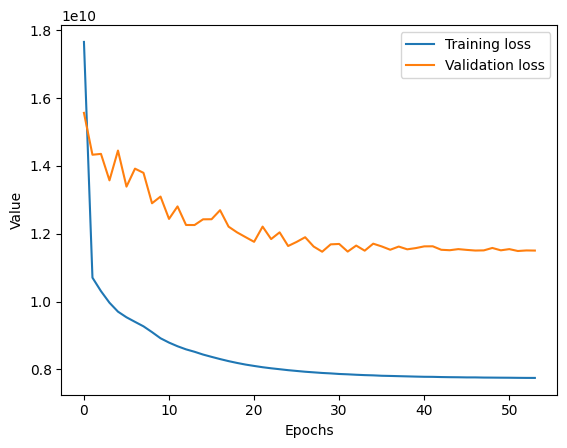

In [174]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

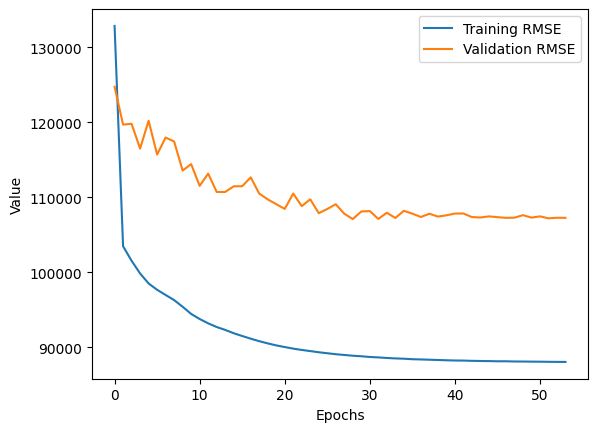

In [175]:
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

In [176]:
#### 存檔用
# model_combined.save('/content/my_drive/MyDrive/BDSE34期末報告_房價/stacking_models/c591_CNN_CBAM_v2_best_0710.h5') # 模型的副檔名記得是.h5

# testing set

In [177]:
X_times_test.shape

(5298, 5, 23)

In [178]:
pred_y_test = model_combined.predict([X_times_test, non_time_test])

166/166 [==============================] - 1s 2ms/step


In [179]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
def rmse(predictions, targets):
    return np.sqrt(mean_squared_error(predictions, targets))

In [180]:
# NN 的validation跟test是偏像的

print(f"test mae:{mean_absolute_error(pred_y_test, y_final_test)}")
print(f"test RMSE:{rmse(pred_y_test, y_final_test)}")
r2_score_linear_train = r2_score(y_final_test, pred_y_test)
print('R2_score (test): ', r2_score_linear_train)
print('-'*50)

test mae:84962.31022785722
test RMSE:119392.58483727608
R2_score (test):  0.7286192259031181
--------------------------------------------------


In [181]:
final_test_data['new_per_ping'].describe()

count    5.298000e+03
mean     5.002125e+05
std      2.292075e+05
min      2.645503e+04
25%      3.393590e+05
50%      4.683932e+05
75%      6.286080e+05
max      1.443124e+06
Name: new_per_ping, dtype: float64

# 591資料驗證

In [182]:
df_591 = pd.read_csv('/content/my_drive/MyDrive/BDSE34期末報告_房價/all_data/c591_no_eco_for_xgb_version3.csv', encoding='utf-8')

In [183]:
df_591['year_month_for_combine'] = '2024-06-01'

In [184]:
df_591['year_month_for_combine'] = pd.to_datetime(df_591['year_month_for_combine']).dt.to_period('M')

In [185]:
only_eco_file_path = '/content/my_drive/MyDrive/BDSE34期末報告_房價/all_data/final_eco_df_to_11306_fillna_v2.csv'
only_eco_df = pd.read_csv(only_eco_file_path, encoding='utf-8')

In [186]:
only_eco_df.drop('year_month_for_combine', axis=1, inplace=True)

In [187]:
window_df_591 = create_windows_of_each_eco_index(only_eco_df, 5)

<ipython-input-133-abb8de1a450b>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars_shift_df[f'{var}_lag_{lag}'] = only_eco_df[var].shift(lag)
<ipython-input-133-abb8de1a450b>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars_shift_df[f'{var}_lag_{lag}'] = only_eco_df[var].shift(lag)
<ipython-input-133-abb8de1a450b>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1

In [188]:
window_df_591['date'] = pd.to_datetime(window_df_591['date'])
window_df_591['year_month_for_combine'] = window_df_591['date'].dt.to_period('M')
# df_591['year_month_for_combine'] = pd.to_datetime(df_591['year_month_for_combine'])
# df_591['year_month_for_combine'] = df_591['year_month_for_combine'].dt.to_period('M')

<ipython-input-188-b84b15953eea>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  window_df_591['year_month_for_combine'] = window_df_591['date'].dt.to_period('M')


In [189]:
df_591 = df_591.merge(window_df_591, right_on='year_month_for_combine', left_on='year_month_for_combine', how='inner')

In [190]:
df_591.info(max_cols=239)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51073 entries, 0 to 51072
Data columns (total 211 columns):
 #    Column                                Non-Null Count  Dtype         
---   ------                                --------------  -----         
 0    building_age                          51073 non-null  float64       
 1    total_area_ping                       51073 non-null  float64       
 2    community_name                        51073 non-null  int64         
 3    has_parking_space                     51073 non-null  int64         
 4    total_floors                          51073 non-null  float64       
 5    transaction_floors                    51073 non-null  float64       
 6    target_floors                         51073 non-null  float64       
 7    bedrooms                              51073 non-null  float64       
 8    living_rooms                          51073 non-null  float64       
 9    bathrooms                             51073 non-null  float

In [191]:
df_591.drop('date', axis=1, inplace=True)

In [192]:
df_591.rename(columns={'target_floors': 'target_floor'}, inplace=True)

In [193]:
df_591_reindex = df_591.reindex(main_df_col_list, axis=1)

In [194]:
len(main_df_col_list)

213

In [195]:
df_591_reindex.fillna(value=0, inplace=True)

In [196]:
df_591_reindex.info(max_cols=213)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51073 entries, 0 to 51072
Data columns (total 213 columns):
 #    Column                                Non-Null Count  Dtype    
---   ------                                --------------  -----    
 0    community_name                        51073 non-null  int64    
 1    main_building_ratio                   51073 non-null  float64  
 2    building_age                          51073 non-null  float64  
 3    total_area_ping                       51073 non-null  float64  
 4    total_floors                          51073 non-null  float64  
 5    target_floor                          51073 non-null  float64  
 6    transaction_floors                    51073 non-null  float64  
 7    bedrooms                              51073 non-null  float64  
 8    living_rooms                          51073 non-null  float64  
 9    bathrooms                             51073 non-null  float64  
 10   year_month_for_combine                51073 

In [197]:
X_591 = df_591_reindex.drop(['new_per_ping', 'year_month_for_combine'], axis=1)
y_591 = df_591_reindex['new_per_ping']

In [198]:
X_591.info(max_cols=211)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51073 entries, 0 to 51072
Data columns (total 211 columns):
 #    Column                                Non-Null Count  Dtype  
---   ------                                --------------  -----  
 0    community_name                        51073 non-null  int64  
 1    main_building_ratio                   51073 non-null  float64
 2    building_age                          51073 non-null  float64
 3    total_area_ping                       51073 non-null  float64
 4    total_floors                          51073 non-null  float64
 5    target_floor                          51073 non-null  float64
 6    transaction_floors                    51073 non-null  float64
 7    bedrooms                              51073 non-null  float64
 8    living_rooms                          51073 non-null  float64
 9    bathrooms                             51073 non-null  float64
 10   Public_Activity_Space_under_250_m     51073 non-null  float64
 11   

In [199]:
X_non_time_591 = X_591.iloc[:,0:95]
time_series_591 = X_591.iloc[:,96:]

In [200]:
X_non_time_591 = mm_scaler_for_non.transform(X_non_time_591)

time_series_591 = scaler_for_time.transform(time_series_591)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [201]:
arry_index_v = time_series_591.shape[0] # 抓總筆數   # time_series_591
X_shift_list_591 = []

for each_index in range(arry_index_v):
    # 每一筆資料抓出來
    each_array_v = time_series_591[each_index].reshape(5,23)

    X_shift_list_591.append(each_array_v)

X_times_591 = np.array(X_shift_list_591)
X_times_591.shape

(51073, 5, 23)

In [202]:
pred_y_591 = model_combined.predict([X_times_591, X_non_time_591])

1597/1597 [==============================] - 3s 2ms/step


In [203]:
# NN 的validation跟test是偏像的

print(f"test mae:{mean_absolute_error(pred_y_591, y_591)}")
print(f"test RMSE:{rmse(pred_y_591, y_591)}")
r2_score_linear_train = r2_score(y_591, pred_y_591)
print('R2_score (test): ', r2_score_linear_train)
print('-'*50)

test mae:176107.23790580392
test RMSE:263830.96175632917
R2_score (test):  0.38360803143975397
--------------------------------------------------


# 將模型檔案載入，繼續訓練

In [204]:
# 將模型檔案載入
# model_combined = tf.keras.models.load_model('/content/my_drive/MyDrive/BDSE34期末報告_房價/trained_models/c591_CNN_CBAM_v2_best_0710.h5')

In [205]:
# model_loaded.fit([X_times_train, non_time_train], y_train, epochs=10, batch_size=32, callbacks=[checkpoint_seq])

In [206]:
# model_loaded.save('/content/my_drive/MyDrive/BDSE34期末報告_房價/trained_models/model_save_test.h5') # 模型的副檔名記得是.h5